In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
sns.set(font_scale=1.1)

## Load Dataset

In [2]:
# import dataset and using first column as index
raw_df = pd.read_csv("postpaid_datamart.csv",index_col=0)
raw_df.head(3)

,OG_INTL_FREE_CALL_MOU,OG_ONN_FREE_CALL_MOU,FREE_GPRS_MB,TOTAL_REVENUE,TOTAL_REVENUE_VAS,ROAMING_REV,F_CHURN_3M,MONTH
803985,NaN,NaN,29918.731,18.00,9.00,0.0,1,october
431536,NaN,NaN,0.013,9.76,4.88,0.0,1,october
59287,NaN,NaN,14688.529,36.00,18.00,0.0,1,october


In [3]:
# check data shape
raw_df.shape

(16295, 8)

In [4]:
# check churn distribution
raw_df['F_CHURN_3M'].value_counts(normalize=True)

0    0.920528
1    0.079472
Name: F_CHURN_3M, dtype: float64

## Train Test Split

In [5]:
# train & test split to avoid data leakage during data transformation 
# as data traget variable is highly imbalance doing stratified resampling
# this ensures train & test both same target distribution

raw_train, raw_test = train_test_split(raw_df,random_state=120, stratify = raw_df['F_CHURN_3M'])

# copying raw_train and raw_test to avoid pandas copy with setting warning
raw_train = raw_train.copy()
raw_test = raw_test.copy()

print(f"Train shape {raw_train.shape}")
print(f"Test shape {raw_test.shape}")

Train shape (12221, 8)
Test shape (4074, 8)


## Descriptive Stats

In [6]:
# check train target distribution
raw_train['F_CHURN_3M'].value_counts(normalize=True)

0    0.920547
1    0.079453
Name: F_CHURN_3M, dtype: float64

In [7]:
# check test target distribution
raw_test['F_CHURN_3M'].value_counts(normalize=True)

0    0.920471
1    0.079529
Name: F_CHURN_3M, dtype: float64

In [8]:
# check data type
pd.DataFrame({"Data type":raw_train.dtypes})

,Data type
OG_INTL_FREE_CALL_MOU,float64
OG_ONN_FREE_CALL_MOU,float64
FREE_GPRS_MB,float64
TOTAL_REVENUE,float64
TOTAL_REVENUE_VAS,float64
ROAMING_REV,float64
F_CHURN_3M,int64
MONTH,object


In [9]:
# check descriptive stats numerical attribute
raw_train.describe()

,OG_INTL_FREE_CALL_MOU,OG_ONN_FREE_CALL_MOU,FREE_GPRS_MB,TOTAL_REVENUE,TOTAL_REVENUE_VAS,ROAMING_REV,F_CHURN_3M
count,1370.000000,3908.000000,8620.000000,8640.000000,8640.000000,8620.000000,12221.000000
mean,11.487692,146.235137,26030.457725,24.594481,18.912191,0.128295,0.079453
std,14.346094,409.387012,37833.583673,35.648188,36.924554,1.804082,0.270456
min,0.000000,0.033000,-715.525000,-6.150000,-1.228000,0.000000,0.000000
25%,1.983000,16.220500,2852.335000,10.000000,9.000000,0.000000,0.000000
50%,6.000000,55.216500,12662.488000,18.000000,13.000000,0.000000,0.000000
75%,15.595750,167.637250,35959.059250,30.000000,20.250000,0.000000,0.000000
max,144.683000,20969.583000,680517.491000,1226.269000,2405.819000,79.300000,1.000000


In [10]:
# check descriptive stats ordinal attribute
raw_train.describe(include=np.object)

,MONTH
count,12221
unique,3
top,october
freq,4100


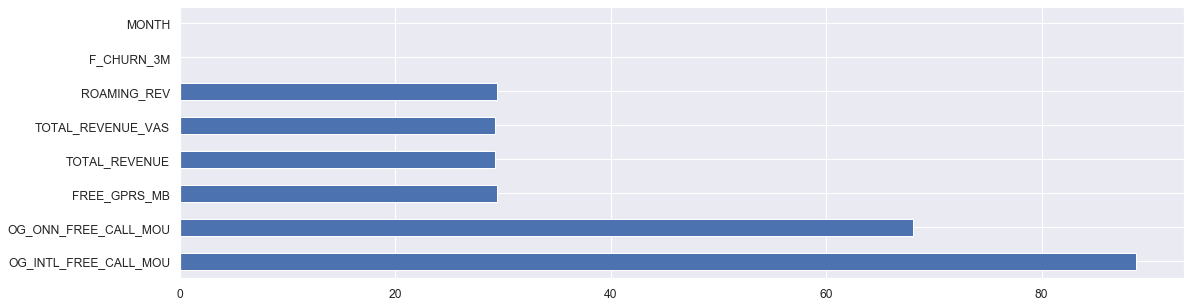

In [11]:
# missing value per%
raw_train.isna().sum().div(raw_train.shape[0]).mul(100).round(2).plot(kind='barh',figsize=(18,5),rot=0)

## Univariate Analysis

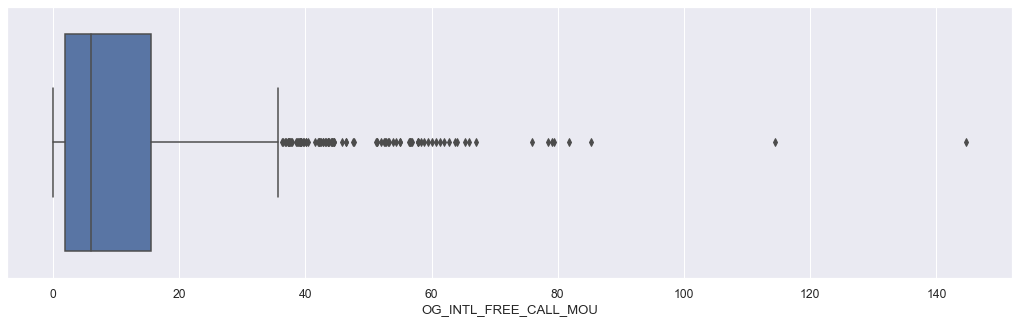

In [12]:
# univariate analysis OG_INTL_FREE_CALL_MOU
plt.figure(figsize=(18,5))
sns.boxplot(x="OG_INTL_FREE_CALL_MOU", data=raw_train)

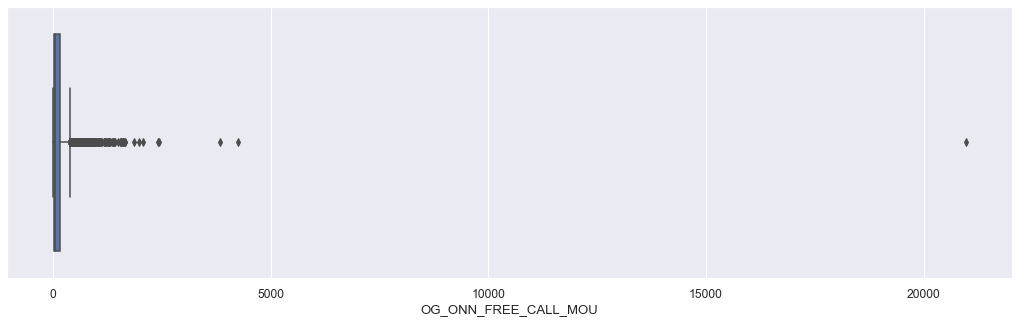

In [13]:
# univariate analysis OG_ONN_FREE_CALL_MOU
plt.figure(figsize=(18,5))
sns.boxplot(x="OG_ONN_FREE_CALL_MOU", data=raw_train)

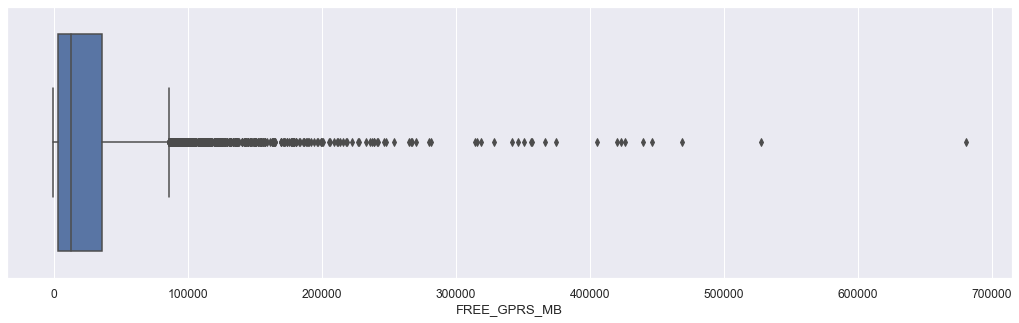

In [14]:
# univariate analysis FREE_GPRS_MB
plt.figure(figsize=(18,5))
sns.boxplot(x="FREE_GPRS_MB", data=raw_train)

In [15]:
# count no of observation where FREE_GPRS_MB is negative
print(f"No of observation where FREE GPRS MB is neagtive {np.sum(raw_train['FREE_GPRS_MB'] < 0)}")

No of observation where FREE GPRS MB is neagtive 3


In [16]:
# checking higher quantile for FREE_GPRS_MB
raw_train['FREE_GPRS_MB'].quantile(q=[0.90,0.95,0.99,1])

0.90     66909.49240
0.95     91598.11545
0.99    168358.17038
1.00    680517.49100
Name: FREE_GPRS_MB, dtype: float64

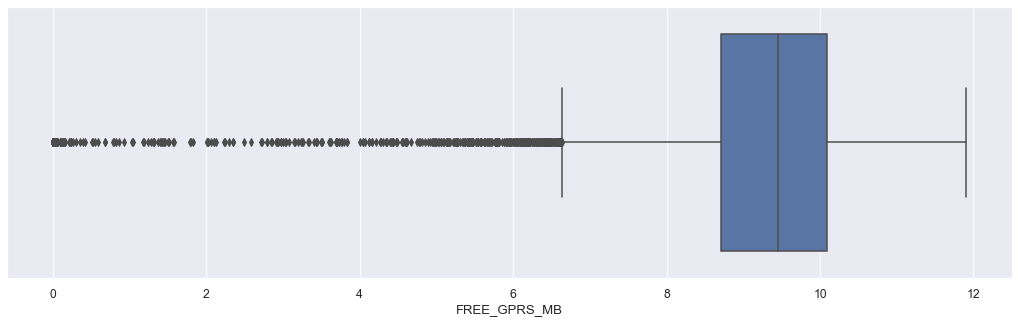

In [17]:
# replacing negative FREE_GPRS_MB value to 0
raw_train.loc[raw_train['FREE_GPRS_MB'] < 0,'FREE_GPRS_MB'] = 0

# replacing nan values with median values
gprs_median = raw_train['FREE_GPRS_MB'].median()
raw_train['FREE_GPRS_MB'].fillna(gprs_median,inplace=True)

# 99th qunatile value
gprs_max_value = raw_train['FREE_GPRS_MB'].quantile(0.99)

# removing outliers - replacing largest 1% values with 99th quantile
raw_train['FREE_GPRS_MB'] = np.where(raw_train['FREE_GPRS_MB'] > gprs_max_value, gprs_max_value,raw_train['FREE_GPRS_MB'])

# remove skenwess using log transformation
# add + 1 in log transformation to avoid log 0 error
raw_train['FREE_GPRS_MB'] = np.log(1+raw_train['FREE_GPRS_MB'])

# check distribution again
plt.figure(figsize=(18,5))
sns.boxplot(x="FREE_GPRS_MB", data=raw_train)

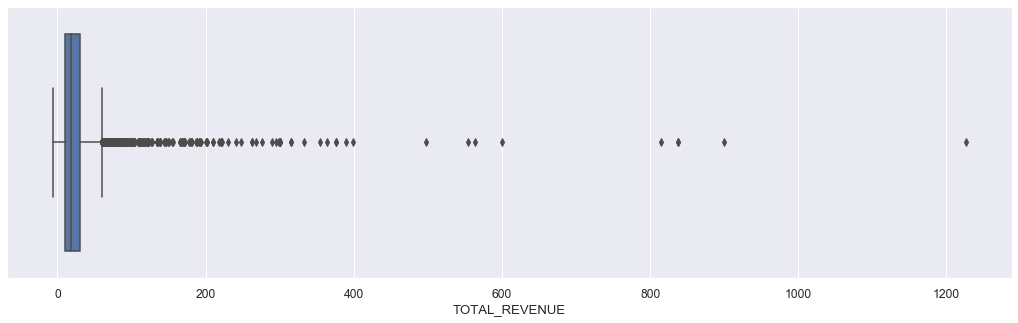

In [18]:
# univariate analysis TOTAL_REVENUE
plt.figure(figsize=(18,5))
sns.boxplot(x="TOTAL_REVENUE", data=raw_train)

In [19]:
# count no of observation where TOTAL_REVENUE is negative
print(f"No of observation where TOTAL_REVENUE is neagtive {np.sum(raw_train['TOTAL_REVENUE'] < 0)}")

No of observation where TOTAL_REVENUE is neagtive 4


In [20]:
# checking higher quantile for FREE_GPRS_MB
raw_train['TOTAL_REVENUE'].quantile(q=[0.90,0.95,0.99,1])

0.90      42.32390
0.95      60.58000
0.99     121.42661
1.00    1226.26900
Name: TOTAL_REVENUE, dtype: float64

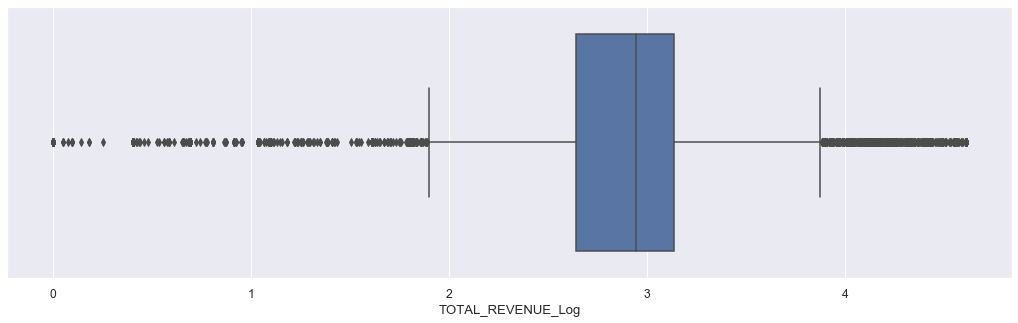

In [21]:
# replacing negative TOTAL_REVENUE value to 0
raw_train.loc[raw_train['TOTAL_REVENUE'] < 0,'TOTAL_REVENUE'] = 0

# replacing nan values with median values
total_rev_median = raw_train['TOTAL_REVENUE'].median()
raw_train['TOTAL_REVENUE'].fillna(total_rev_median,inplace=True)

# 99th qunatile value
total_rev_max_value = raw_train['TOTAL_REVENUE'].quantile(0.99)

# removing outliers - replacing largest 1% values with 99th quantile
raw_train['TOTAL_REVENUE'] = np.where(raw_train['TOTAL_REVENUE'] > total_rev_max_value, 
                                      total_rev_max_value,raw_train['TOTAL_REVENUE'])

# remove skenwess using log transformation
# add + 1 in log transformation to avoid log 0 error
raw_train['TOTAL_REVENUE_Log'] = np.log(1+raw_train['TOTAL_REVENUE'])

# check distribution again
plt.figure(figsize=(18,5))
sns.boxplot(x="TOTAL_REVENUE_Log", data=raw_train)

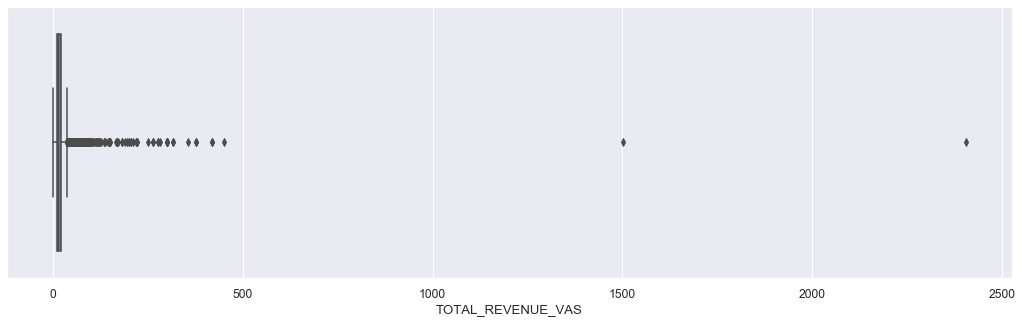

In [22]:
# univariate analysis OG_INTL_FREE_CALL_MOU
plt.figure(figsize=(18,5))
sns.boxplot(x="TOTAL_REVENUE_VAS", data=raw_train)

In [23]:
# count no of observation where TOTAL_REVENUE_VAS is negative
print(f"No of observation where TOTAL_REVENUE_VAS is neagtive {np.sum(raw_train['TOTAL_REVENUE_VAS'] < 0)}")

No of observation where TOTAL_REVENUE_VAS is neagtive 4


In [24]:
# checking higher quantile for FREE_GPRS_MB
raw_train['TOTAL_REVENUE_VAS'].quantile(q=[0.90,0.95,0.99,1])

0.90      32.50000
0.95      40.89050
0.99      82.43123
1.00    2405.81900
Name: TOTAL_REVENUE_VAS, dtype: float64

In [25]:
# replacing negative TOTAL_REVENUE value to 0
raw_train.loc[raw_train['TOTAL_REVENUE_VAS'] < 0,'TOTAL_REVENUE_VAS'] = 0

# replacing nan values with median values
total_rev_vas_median = raw_train['TOTAL_REVENUE_VAS'].median()
raw_train['TOTAL_REVENUE_VAS'].fillna(total_rev_vas_median,inplace=True)

# 99th qunatile value
total_rev_vas_max_value = raw_train['TOTAL_REVENUE_VAS'].quantile(0.99)

# removing outliers - replacing largest 1% values with 99th quantile
raw_train['TOTAL_REVENUE_VAS'] = np.where(raw_train['TOTAL_REVENUE_VAS'] > total_rev_vas_max_value, 
                                      total_rev_vas_max_value,raw_train['TOTAL_REVENUE_VAS'])

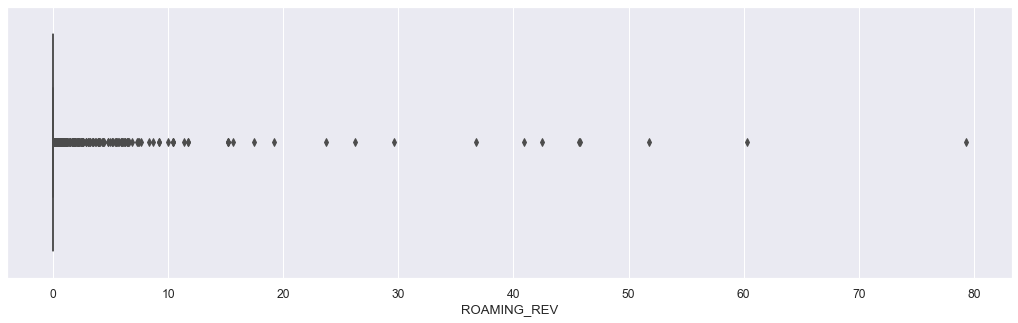

In [26]:
# univariate analysis ROAMING_REV
plt.figure(figsize=(18,5))
sns.boxplot(x="ROAMING_REV", data=raw_train)

In [27]:
# count no of observation where ROAMING_REV is negative
print(f"No of observation where ROAMING_REV is neagtive {np.sum(raw_train['ROAMING_REV'] < 0)}")

No of observation where ROAMING_REV is neagtive 0


In [28]:
# checking higher quantile for FREE_GPRS_MB
raw_train['ROAMING_REV'].quantile(q=[0.90,0.95,0.99,1])

0.90     0.00000
0.95     0.00000
0.99     2.61834
1.00    79.30000
Name: ROAMING_REV, dtype: float64

In [29]:
# replacing nan values with median values
roam_rev_median = raw_train['ROAMING_REV'].median()
raw_train['ROAMING_REV'].fillna(roam_rev_median,inplace=True)

# 99th qunatile value
roam_rev_max_value = raw_train['ROAMING_REV'].quantile(0.99)

# removing outliers - replacing largest 1% values with 99th quantile
raw_train['ROAMING_REV'] = np.where(raw_train['ROAMING_REV'] > roam_rev_max_value, 
                                      roam_rev_max_value,raw_train['ROAMING_REV'])

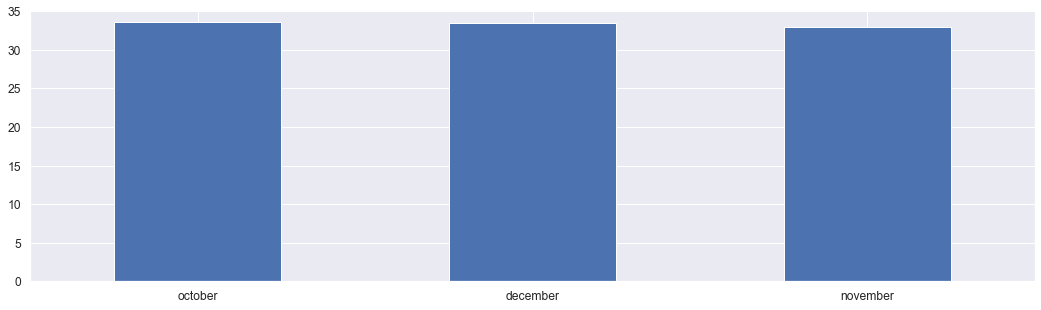

In [30]:
# univariate analysis Month
plt.figure(figsize=(18,5))
raw_train['MONTH'].value_counts(normalize=True).mul(100).plot(kind='bar',rot=0)

## Feature Engineering

In [31]:
# feature enginerring

# creating revene vas % 
# adding 1 in denominator to avoid divide by zero error
raw_train['Revenue_VAS%'] = raw_train['TOTAL_REVENUE_VAS'].div(raw_train['TOTAL_REVENUE']+1)

# check descriptive stats for new variable
raw_train['Revenue_VAS%'].describe()

count    12221.000000
mean         0.742574
std          0.221666
min          0.000000
25%          0.666667
50%          0.684211
75%          0.928571
max          3.825000
Name: Revenue_VAS%, dtype: float64

In [32]:
print(f"observation where revenue vas % is greater 1 :{np.sum(raw_train['Revenue_VAS%']>1)}")

observation where revenue vas % is greater 1 :369


In [33]:
# revenue vas % cannot be more than 100% or 1 so replacing greater 1 value with 1
raw_train['Revenue_VAS%'] = np.where(raw_train['Revenue_VAS%'] > 1, 1,raw_train['Revenue_VAS%'])

In [34]:
# feature enginerring

# creating revene roaming % 
# adding 1 in denominator to avoid divide by zero error
raw_train['ROAMING_REV%'] = raw_train['ROAMING_REV'].div(raw_train['TOTAL_REVENUE']+1)

# check descriptive stats for new variable
raw_train['ROAMING_REV%'].describe()

count    12221.000000
mean         0.000610
std          0.014319
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.476400
Name: ROAMING_REV%, dtype: float64

In [35]:
print(f"observation where ROAMING_REV % is greater 1 :{np.sum(raw_train['ROAMING_REV%']>1)}")

observation where ROAMING_REV % is greater 1 :1


In [36]:
# ROAMING_REV % cannot be more than 100% or 1 so replacing greater 1 value with 1
raw_train['ROAMING_REV%'] = np.where(raw_train['ROAMING_REV%'] > 1, 1,raw_train['ROAMING_REV%'])

In [37]:
# creating binary feature to indicate Not Null and Null values in OG_INTL_FREE_CALL_MOU and OG_ONN_FREE_CALL_MOU
raw_train['OG_INTL_FREE_CALL_MOU_Bool'] = (raw_train['OG_INTL_FREE_CALL_MOU'].notna()).astype(int)
raw_train['OG_ONN_FREE_CALL_MOU_Bool'] = (raw_train['OG_ONN_FREE_CALL_MOU'].notna()).astype(int)

## Multivariate Analysis

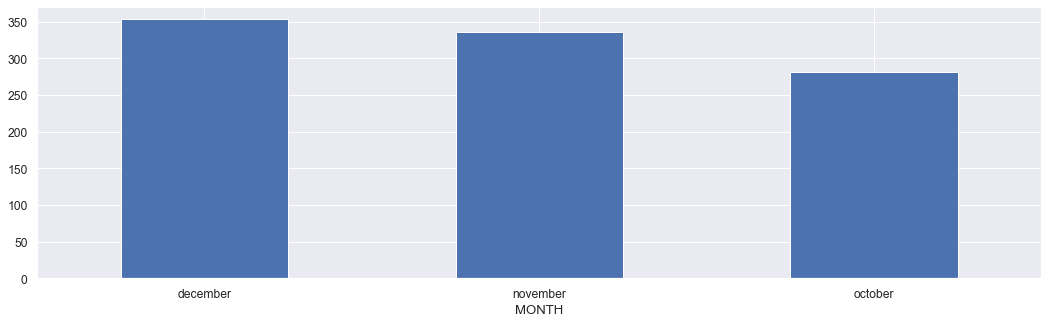

In [38]:
season_churn = raw_train.groupby(['MONTH'])['F_CHURN_3M'].sum()
season_churn.plot(kind='bar',rot=0,figsize=(18,5))

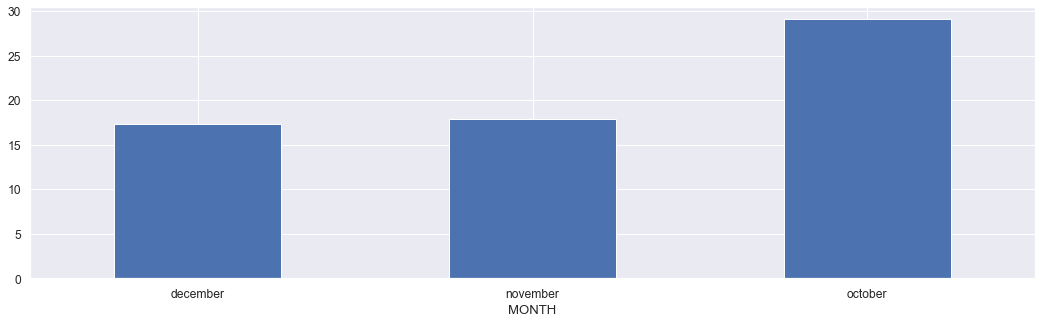

In [39]:
season_revenue = raw_train.groupby(['MONTH'])['TOTAL_REVENUE'].mean()
season_revenue.plot(kind='bar',rot=0,figsize=(18,5))

In [40]:
raw_train.columns

Index(['OG_INTL_FREE_CALL_MOU', 'OG_ONN_FREE_CALL_MOU', 'FREE_GPRS_MB',
       'TOTAL_REVENUE', 'TOTAL_REVENUE_VAS', 'ROAMING_REV', 'F_CHURN_3M',
       'MONTH', 'TOTAL_REVENUE_Log', 'Revenue_VAS%', 'ROAMING_REV%',
       'OG_INTL_FREE_CALL_MOU_Bool', 'OG_ONN_FREE_CALL_MOU_Bool'],
      dtype='object')

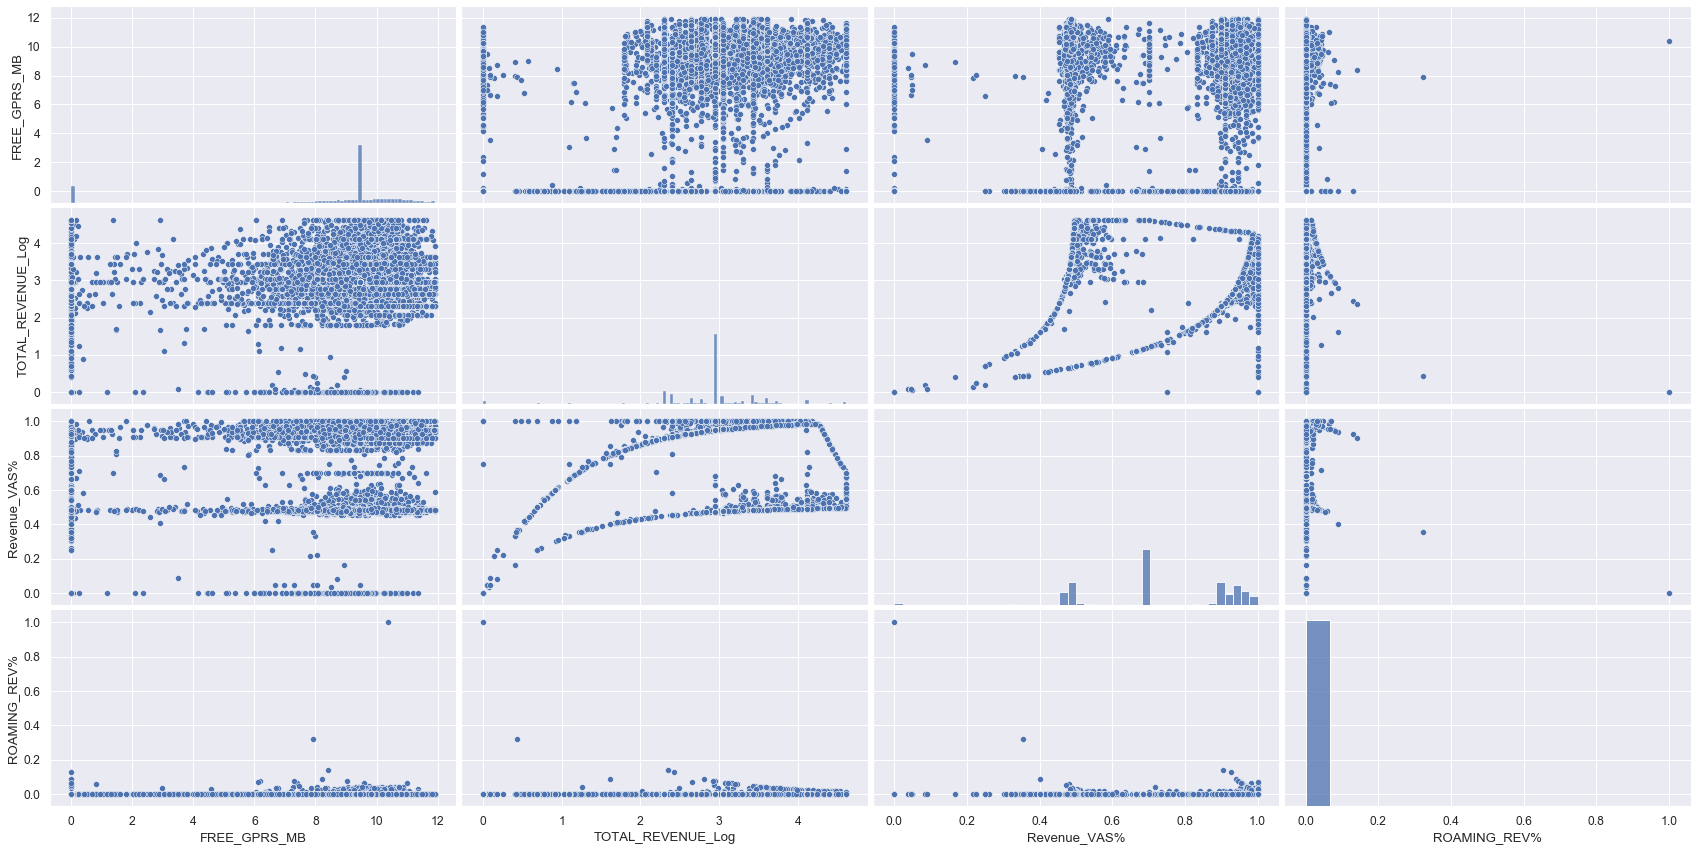

In [41]:
num_features = ['FREE_GPRS_MB','TOTAL_REVENUE_Log','Revenue_VAS%','ROAMING_REV%']
sns.pairplot(raw_train[num_features],aspect=2,height=3)

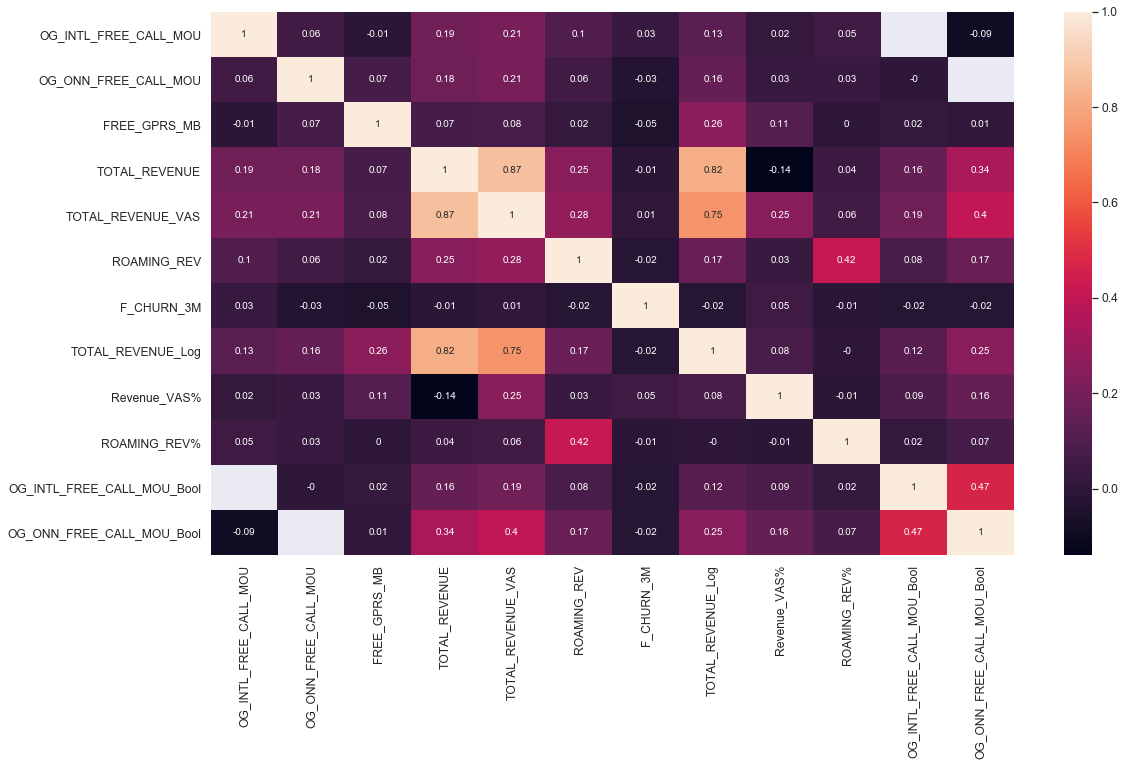

In [42]:
corr = raw_train.corr().round(2)
plt.figure(figsize=(18,10))
sns.heatmap(corr,annot=True)

## Data Transformation

In [43]:
# scale numerical features
scale_features = ['FREE_GPRS_MB','TOTAL_REVENUE_Log','Revenue_VAS%']
scaler = StandardScaler()
scaled_arr = scaler.fit_transform(raw_train[scale_features])
scaled_df = pd.DataFrame(scaled_arr,columns=scale_features,index=raw_train.index)

# one hot encode categorical variable
encode_feature = ['MONTH']
encoder = OneHotEncoder(drop='first')
encode_arr = encoder.fit_transform(raw_train[encode_feature])
encode_df = pd.DataFrame(encode_arr.todense(),columns=encoder.get_feature_names(),index=raw_train.index)

# binary feature 
binary_feature = ['OG_INTL_FREE_CALL_MOU_Bool','OG_ONN_FREE_CALL_MOU_Bool']

# concatenate all the features to form final data frame
x_train = pd.concat([scaled_df,raw_train[binary_feature],encode_df],axis=1,sort=False,ignore_index=False)
x_train.head()

,FREE_GPRS_MB,TOTAL_REVENUE_Log,Revenue_VAS%,OG_INTL_FREE_CALL_MOU_Bool,OG_ONN_FREE_CALL_MOU_Bool,x0_november,x0_october
277671,0.284074,0.063425,-0.260392,0,0,0.0,1.0
1203451,0.284074,0.063425,-0.260392,0,0,0.0,0.0
431160,0.527608,0.810370,1.127886,0,1,1.0,0.0
1170840,0.001084,-0.711130,0.831350,0,1,0.0,0.0
400657,-0.052785,0.382642,-1.256682,0,0,0.0,1.0


In [44]:
y_train = raw_train['F_CHURN_3M']
y_train.head()

277671     0
1203451    0
431160     0
1170840    0
400657     0
Name: F_CHURN_3M, dtype: int64

## Test Data Prep

In [45]:
# replacing negative FREE_GPRS_MB value to 0
raw_test.loc[raw_test['FREE_GPRS_MB'] < 0,'FREE_GPRS_MB'] = 0

# replacing nan values with median values
raw_test['FREE_GPRS_MB'].fillna(gprs_median,inplace=True)

# removing outliers - replacing largest 1% values with 99th quantile
raw_test['FREE_GPRS_MB'] = np.where(raw_test['FREE_GPRS_MB'] > gprs_max_value, gprs_max_value,raw_test['FREE_GPRS_MB'])

# remove skenwess using log transformation
raw_test['FREE_GPRS_MB'] = np.log(1+raw_test['FREE_GPRS_MB'])

# replacing negative TOTAL_REVENUE value to 0
raw_test.loc[raw_test['TOTAL_REVENUE'] < 0,'TOTAL_REVENUE'] = 0

# replacing nan values with median values
raw_test['TOTAL_REVENUE'].fillna(total_rev_median,inplace=True)


# removing outliers - replacing largest 1% values with 99th quantile
raw_test['TOTAL_REVENUE'] = np.where(raw_test['TOTAL_REVENUE'] > total_rev_max_value, 
                                      total_rev_max_value,raw_test['TOTAL_REVENUE'])

# remove skenwess using log transformation
raw_test['TOTAL_REVENUE_Log'] = np.log(1+raw_test['TOTAL_REVENUE'])

# replacing negative TOTAL_REVENUE value to 0
raw_test.loc[raw_test['TOTAL_REVENUE_VAS'] < 0,'TOTAL_REVENUE_VAS'] = 0

# replacing nan values with median values
raw_test['TOTAL_REVENUE_VAS'].fillna(total_rev_vas_median,inplace=True)


# removing outliers - replacing largest 1% values with 99th quantile
raw_test['TOTAL_REVENUE_VAS'] = np.where(raw_test['TOTAL_REVENUE_VAS'] > total_rev_vas_max_value, 
                                      total_rev_vas_max_value,raw_test['TOTAL_REVENUE_VAS'])

# replacing nan values with median values
raw_test['ROAMING_REV'].fillna(roam_rev_median,inplace=True)


# removing outliers - replacing largest 1% values with 99th quantile
raw_test['ROAMING_REV'] = np.where(raw_test['ROAMING_REV'] > roam_rev_max_value, 
                                      roam_rev_max_value,raw_test['ROAMING_REV'])

# creating revene vas % 
raw_test['Revenue_VAS%'] = raw_test['TOTAL_REVENUE_VAS'].div(raw_test['TOTAL_REVENUE']+1)


# revenue vas % cannot be more than 100% or 1 so replacing greater 1 value with 1
raw_test['Revenue_VAS%'] = np.where(raw_test['Revenue_VAS%'] > 1, 1,raw_test['Revenue_VAS%'])

# creating revene roaming % 

raw_test['ROAMING_REV%'] = raw_test['ROAMING_REV'].div(raw_test['TOTAL_REVENUE']+1)


# ROAMING_REV % cannot be more than 100% or 1 so replacing greater 1 value with 1
raw_test['ROAMING_REV%'] = np.where(raw_test['ROAMING_REV%'] > 1, 1,raw_test['ROAMING_REV%'])

# creating binary feature to indicate Not Null and Null values in OG_INTL_FREE_CALL_MOU and OG_ONN_FREE_CALL_MOU
raw_test['OG_INTL_FREE_CALL_MOU_Bool'] = (raw_test['OG_INTL_FREE_CALL_MOU'].notna()).astype(int)

raw_test['OG_ONN_FREE_CALL_MOU_Bool'] = (raw_test['OG_ONN_FREE_CALL_MOU'].notna()).astype(int)


# scale numerical features
scaled_arr = scaler.transform(raw_test[scale_features])
scaled_df = pd.DataFrame(scaled_arr,columns=scale_features,index=raw_test.index)

# one hot encode categorical variable
encode_arr = encoder.transform(raw_test[encode_feature])
encode_df = pd.DataFrame(encode_arr.todense(),columns=encoder.get_feature_names(),index=raw_test.index)


# concatenate all the features to form final data frame
x_test = pd.concat([scaled_df,raw_test[binary_feature],encode_df],axis=1,sort=False,ignore_index=False)
x_test.head()

,FREE_GPRS_MB,TOTAL_REVENUE_Log,Revenue_VAS%,OG_INTL_FREE_CALL_MOU_Bool,OG_ONN_FREE_CALL_MOU_Bool,x0_november,x0_october
959195,0.533170,-0.846203,0.787215,0,0,1.0,0.0
1017295,0.300197,-0.369358,0.925923,0,0,0.0,0.0
143062,0.284074,0.063425,-0.260392,0,0,0.0,0.0
1038267,0.284074,0.063425,-0.260392,0,0,1.0,0.0
663422,-0.679514,0.786436,1.119284,0,1,1.0,0.0


In [46]:
y_test = raw_test['F_CHURN_3M']
y_test.head()

959195     0
1017295    0
143062     0
1038267    0
663422     1
Name: F_CHURN_3M, dtype: int64

## Logistic Regression

In [54]:
# fit model
model = LogisticRegression(class_weight='balanced',random_state=456)
model.fit(x_train,y_train)

LogisticRegression(class_weight='balanced', random_state=456)

In [55]:
# train prediction
pred_train = model.predict(x_train)
print("=============== Train Performance ==================")
print(classification_report(y_train,pred_train))

# test prediction
pred_test = model.predict(x_test)
print("=============== Test Performance ==================")
print(classification_report(y_test,pred_test))

=============== Train Performance ==================
              precision    recall  f1-score   support

           0       0.94      0.51      0.66     11250
           1       0.10      0.62      0.17       971

    accuracy                           0.52     12221
   macro avg       0.52      0.57      0.42     12221
weighted avg       0.87      0.52      0.62     12221

=============== Test Performance ==================
              precision    recall  f1-score   support

           0       0.94      0.53      0.67      3750
           1       0.10      0.60      0.17       324

    accuracy                           0.53      4074
   macro avg       0.52      0.56      0.42      4074
weighted avg       0.87      0.53      0.63      4074



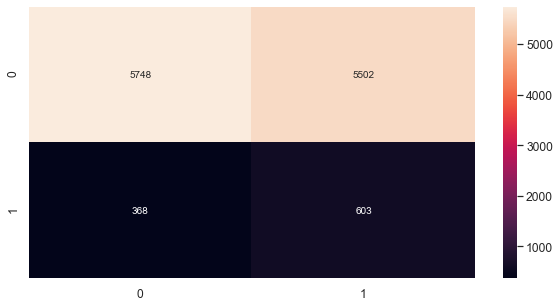

In [49]:
plt.figure(figsize=(10,5))
sns.heatmap(confusion_matrix(y_train,pred_train),annot=True,fmt='g')

In [50]:
# important features
feature_imp = pd.DataFrame({'Features':x_train.columns,'Coefficient': model.coef_[0]})
feature_imp

,Features,Coefficient
0,FREE_GPRS_MB,-0.169367
1,TOTAL_REVENUE_Log,-0.090475
2,Revenue_VAS%,0.391862
3,OG_INTL_FREE_CALL_MOU_Bool,-0.174543
4,OG_ONN_FREE_CALL_MOU_Bool,-0.169016
5,x0_november,-0.047496
6,x0_october,0.454224


([0, 1, 2, 3, 4, 5, 6], <a list of 7 Text xticklabel objects>)

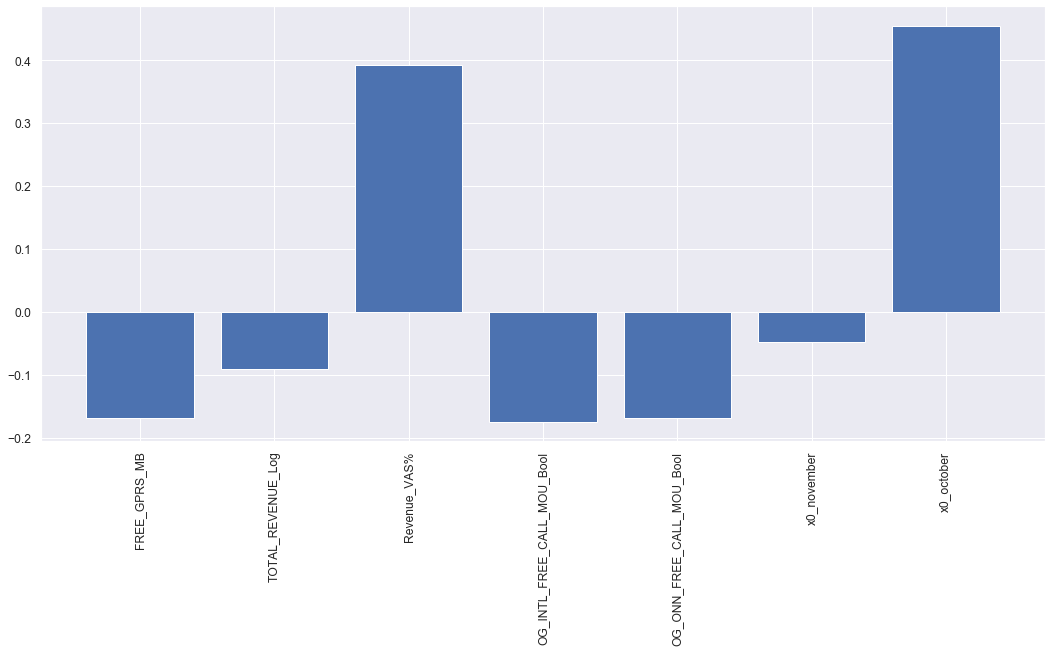

In [51]:
plt.figure(figsize=(18,8))
plt.bar(x=feature_imp['Features'],height=feature_imp['Coefficient'])
plt.xticks(rotation=90)